<a href="https://colab.research.google.com/github/LuceroZaHe/momentos_evaluativos/blob/main/ME03-G06-%5B1088344331%5D-%5B1026303103%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Parte 1. Lectura de datos crudos.
**Libreria de XM para datos del mercado eléctrico**

In [21]:
!pip install pydataxm # Instalación de libreria XM

In [31]:
# Libreria lectura de datos XM
from pydataxm import *

#Librerias básicas manejo de datos
import datetime as dt
import pandas as pd
import numpy as np

#Librerias visualización
import matplotlib as mpl
import matplotlib.pyplot as plt

# Librerias análisis exploratorio
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Librerias preparación de datos para modelo
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Lectura desde API XM (Administrador del mercado mayorista de energía en Colombia). Base de datos con colecciones y variables del mercado mayorista de energía, en la que converge información relacionada con la demanda energética diaria del país, las diversas fuentes de generación electrica que componen la matriz energética colombiana, despacho térmico para la generación de energía electrica a partir diferentes tipos de combustible, variables históricas de precios, agentes generadores, entre otros.



In [23]:
# Creación de objeto API
objetoAPI = pydataxm.ReadDB()
# Con esta línea de código traemos todas las colecciones de datos de xm
df =objetoAPI.get_collections()
df.head(20)

,MetricId,MetricName,Entity,MaxDays,Type,Url,Filter,MetricUnits,MetricDescription
0,DemaReal,Demanda Real por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Demanda de usuarios regulados y no regulados q...
1,DemaReal,Demanda Real por Agente,Agente,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Comercializador,kWh,Demanda de usuarios regulados y no regulados q...
2,ExpoMoneda,Exportaciones Moneda por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP,Transferencias de Energia desde Colombia hacia...
3,DemaCome,Demanda Comercial por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Considera la demanda propia de cada comerciali...
4,Gene,Generación por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Generacion neta de cada una de las plantas Nac...
5,GeneIdea,Generación Ideal por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Despacho de generacion que resulta de consider...
6,PrecBolsNaci,Precio Bolsa Nacional por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP/kWh,Precio de oferta de la última planta flexible ...
7,RestAliv,Restricciones Aliviadas por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP,“Es el valor a cargo de los comercializadores ...
8,ConsCombustibleMBTU,Consumo Combustible MBTU por Recurso,Recurso,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Submercado Generación,MBTU,Los generadores térmicos deben reportar diaria...
9,Gene,Generación por Recurso,Recurso,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Submercado Generación,kWh,Generacion neta de cada una de las plantas Nac...


### Lectura de datos crudos desde la base de datos de XM de consumo de combustible de los agentes del sistema en MBTU
**Descripción de las variables:**
1.  Id: indicador de recurso
2. Values_Name: Tipo de combustible utilizado para la generación
3. Values_code: Nombre codificado de la central térmica.
4. Values_Hour0"n": Cantidad de energía consumida en MBTU en la hora "n" por el agente termico en un día particular.
5. Date: Día de consumo.

In [24]:
# Lectura de datos crudos del consumo de combustible en MBTU de las termoelectricas durante el periodo 2018-2023.
# Se realiza una lectura de consumo de combustible desde una fecha inicio hasta una fecha fin.
fecha_inicio = dt.date(2018, 1, 1)
fecha_fin = dt.date(2024, 1, 31)
df_ConsCombustibleMBTU = objetoAPI.request_data("ConsCombustibleMBTU",
                                    "Recurso",
                                    fecha_inicio,
                                    fecha_fin)
# tabla de datos inicial con la que se va a trabajar.
df_ConsCombustibleMBTU

,Id,Values_Name,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,...,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date
0,Recurso,ACPM,TDR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,350.64000,331.69000,144.61000,343.74000,355.01000,358.40000,356.67000,41.44000,NaN,2024-01-30
1,Recurso,ACPM,TRN1,19.45000,9.38000,12.50000,9.03000,15.98000,9.03000,8.68000,...,21.53000,11.46000,18.41000,11.46000,11.46000,11.46000,11.46000,9.03000,19.45000,2024-01-30
2,Recurso,CARBON,GEC3,1757.84000,1757.00000,1760.78000,1765.19000,1766.03000,1767.08000,1775.70000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-30
3,Recurso,CARBON,PPA1,375.53976,381.02117,379.09640,383.40622,375.53976,390.56135,381.48145,...,383.02963,379.76589,377.42269,391.69111,390.26845,371.73206,378.46876,372.10864,380.85380,2024-01-30
4,Recurso,CARBON,PPA2,808.89443,820.67343,809.17488,805.52900,807.98296,811.97941,813.24144,...,834.34547,818.71026,819.20105,817.58845,808.40364,814.71382,808.68409,799.49928,807.77262,2024-01-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,Recurso,GAS,TBST,3806.94000,3828.86000,3826.86000,3826.86000,3828.86000,3828.86000,3830.84000,...,3833.84000,3834.83000,3834.83000,3834.83000,3836.83000,3863.73000,3882.65000,3929.48000,3830.84000,2018-01-30
325,Recurso,GAS,TFL1,1180.18000,788.82000,641.95000,642.14000,642.14000,642.34000,642.34000,...,1116.59000,1116.34000,1115.85000,1112.64000,1055.30000,1158.22000,1208.25000,1173.89000,914.28000,2018-01-30
326,Recurso,GAS,TGJ1,439.52000,326.62000,100.00000,32.33000,33.33000,34.33000,33.33000,...,609.90000,158.61000,152.78000,150.98000,158.97000,174.74000,171.65000,159.28000,170.94000,2018-01-30
327,Recurso,GAS,TGJ2,118.75000,139.59000,216.07000,239.40000,352.12000,391.08000,536.36000,...,75.32000,33.68000,76.92000,148.00000,148.24000,60.18000,NaN,62.24000,NaN,2018-01-30


### Parte 2. Exploración y limpieza de datos

In [25]:
# Exploración de los tipos de combustibles con los que se genera energia.
df_ConsCombustibleMBTU['Values_Name'].unique()

array(['ACPM', 'CARBON', 'GAS', 'GAS NI', 'COMBUSTOLEO', 'CRUDO'],
      dtype=object)

In [26]:
# Se crea una nueva variable para realizar las transformaciones a los datos crudos.
df_g = df_ConsCombustibleMBTU
# Los valores nulos se inicializan con cero, esto se realiza, ya que en los datos los momentos en que una central térmica no esta generando energía se muestran como Nan.
df_g = df_g.fillna(0)
# Se suman los valores horarios correspondientes a las 24 horas de un día para tener una variable de consumo diario.
df_g['MBTU_daily'] = df_g.sum(axis=1, numeric_only=True)
# Se filtran unicamente las centrales térmicas que producen con Gas.
df_g = df_g[df_g['Values_Name']=='GAS']
df_g

,Id,Values_Name,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,...,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date,MBTU_daily
13,Recurso,GAS,3ENA,1778.6990,1712.5532,516.0759,257.5841,298.9342,356.8148,346.4952,...,344.8469,344.4647,344.7274,367.1105,358.9647,346.7579,344.9663,347.0207,2024-01-30,11173.2206
14,Recurso,GAS,MRL1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1141.8661,1141.3698,1141.7484,1141.2597,1141.5749,1140.5698,1142.7371,1140.2799,2024-01-30,18815.7126
15,Recurso,GAS,PRG1,799.8430,787.9880,794.8080,779.6200,770.6840,780.9830,783.4870,...,780.6940,782.6320,784.1680,778.1870,788.5200,794.8000,765.2780,763.1690,2024-01-30,18740.0010
16,Recurso,GAS,TBST,192.9026,192.8673,192.6840,192.8973,193.2053,197.8334,207.2613,...,238.3275,237.8643,238.2738,238.0446,237.1353,234.9865,234.8861,229.6111,2024-01-30,5408.5958
17,Recurso,GAS,TFL1,550.0000,550.0000,550.0000,550.0000,540.0000,540.0000,540.0000,...,540.0000,540.0000,540.0000,540.0000,540.0000,540.0000,540.0000,540.0000,2024-01-30,13000.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,Recurso,GAS,TBST,3806.9400,3828.8600,3826.8600,3826.8600,3828.8600,3828.8600,3830.8400,...,3834.8300,3834.8300,3834.8300,3836.8300,3863.7300,3882.6500,3929.4800,3830.8400,2018-01-30,92174.4600
325,Recurso,GAS,TFL1,1180.1800,788.8200,641.9500,642.1400,642.1400,642.3400,642.3400,...,1116.3400,1115.8500,1112.6400,1055.3000,1158.2200,1208.2500,1173.8900,914.2800,2018-01-30,21138.6800
326,Recurso,GAS,TGJ1,439.5200,326.6200,100.0000,32.3300,33.3300,34.3300,33.3300,...,158.6100,152.7800,150.9800,158.9700,174.7400,171.6500,159.2800,170.9400,2018-01-30,3173.9500
327,Recurso,GAS,TGJ2,118.7500,139.5900,216.0700,239.4000,352.1200,391.0800,536.3600,...,33.6800,76.9200,148.0000,148.2400,60.1800,0.0000,62.2400,0.0000,2018-01-30,5163.0800


In [27]:
# Se agrupan los datos por fecha y se suman los valores de MBTU
df_agrupado = df_g.groupby('Date')['MBTU_daily'].sum().reset_index()
df_agrupado

,Date,MBTU_daily
0,2018-01-01,116056.5306
1,2018-01-02,117098.6054
2,2018-01-03,120172.0998
3,2018-01-04,118897.0103
4,2018-01-05,125215.0057
...,...,...
2217,2024-01-27,143683.5824
2218,2024-01-28,135181.7737
2219,2024-01-29,135354.0545
2220,2024-01-30,198613.4700


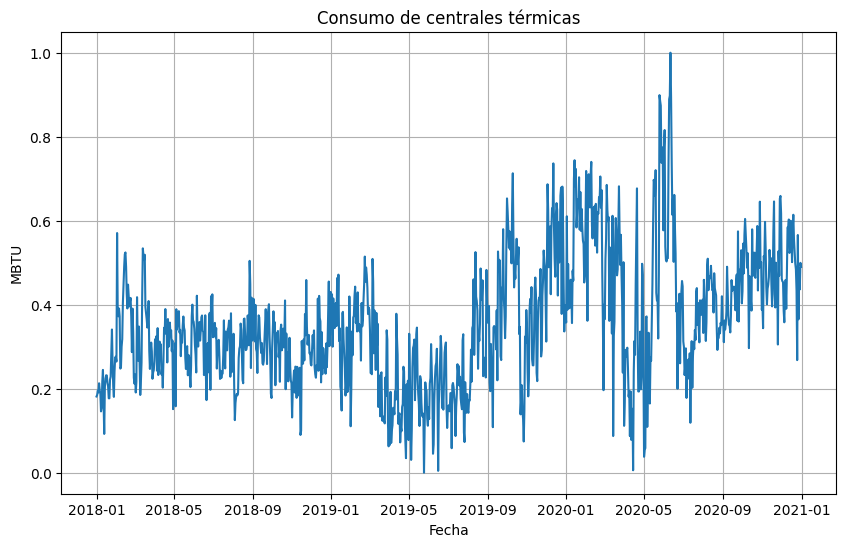

In [45]:
# Grafica exploratoria de datos apartir de una fecha inicio y fin que se encuentren en el rango inicial de descarga.
df_agrupado['Date'] = pd.to_datetime(df_agrupado['Date'])
fecha_inicio = dt.datetime.strptime("2018-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2020-12-31", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango = df_agrupado[(df_agrupado['Date'] >= fecha_inicio) & (df_agrupado['Date'] <= fecha_fin)]

plt.figure(figsize=(10, 6))
plt.plot(df_rango['Date'], df_rango['MBTU_daily'])
plt.title('Consumo de centrales térmicas')
plt.xlabel('Fecha')
plt.ylabel('MBTU')
plt.grid(True)
plt.show()

### Parte 3. Creación de datasets para entrenamiento y prueba de los modelos predictivos.
- Se debe considerar si es necesario excluir del estudio una epoca

In [29]:
# Conjunto de datos de entrenamiento y prueba para el modelo Sarimax y otros

# Separar las características (X) y la variable objetivo (y)
X = df_agrupado.drop(columns=['MBTU_daily'])  # Características
y = df_agrupado['MBTU_daily']  # Variable objetivo

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 'test_size' especifica la proporción de datos que se utilizarán para el conjunto de prueba (en este caso, 20%)
# 'random_state' asegura que la división sea reproducible

# Ahora tienes tus datos divididos en X_train, X_test (características) y y_train, y_test (variable objetivo)
# Puedes utilizar X_train y y_train para entrenar tu modelo y X_test para evaluar su rendimiento


In [30]:
# Paso 2: Normalización de datos
scaler = MinMaxScaler()
df_agrupado['MBTU_daily'] = scaler.fit_transform(df_agrupado['MBTU_daily'].values.reshape(-1, 1))

# Paso 3: Creación de secuencias
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

sequence_length = 2  # Longitud de la secuencia
X = create_sequences(df_agrupado['MBTU_daily'].values, sequence_length)
y = df_agrupado['MBTU_daily'].values[sequence_length:]

# Paso 4: División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# X_train y y_train serán utilizados para entrenar el modelo de RNN
# X_test y y_test serán utilizados para evaluar el rendimiento del modelo
X_train

array([[0.18146777, 0.18505469],
       [0.18505469, 0.19563393],
       [0.19563393, 0.19124496],
       ...,
       [0.25241083, 0.31044019],
       [0.31044019, 0.3712372 ],
       [0.3712372 , 0.2735733 ]])

**Parte 4.** Análisis exploratorio de verificaciones en serie de tiempo.

- Se realiza análisis de estacionalidad, tendencia y error de los datos.
- Se reliza test de dicked fuller.
- El análisis y pruebas se realizan en base al dataframe "df_rango" en un rango particular de datos.

In [47]:
df_rango['Date']

0      2018-01-01
1      2018-01-02
2      2018-01-03
3      2018-01-04
4      2018-01-05
          ...    
1091   2020-12-27
1092   2020-12-28
1093   2020-12-29
1094   2020-12-30
1095   2020-12-31
Name: Date, Length: 1096, dtype: datetime64[ns]

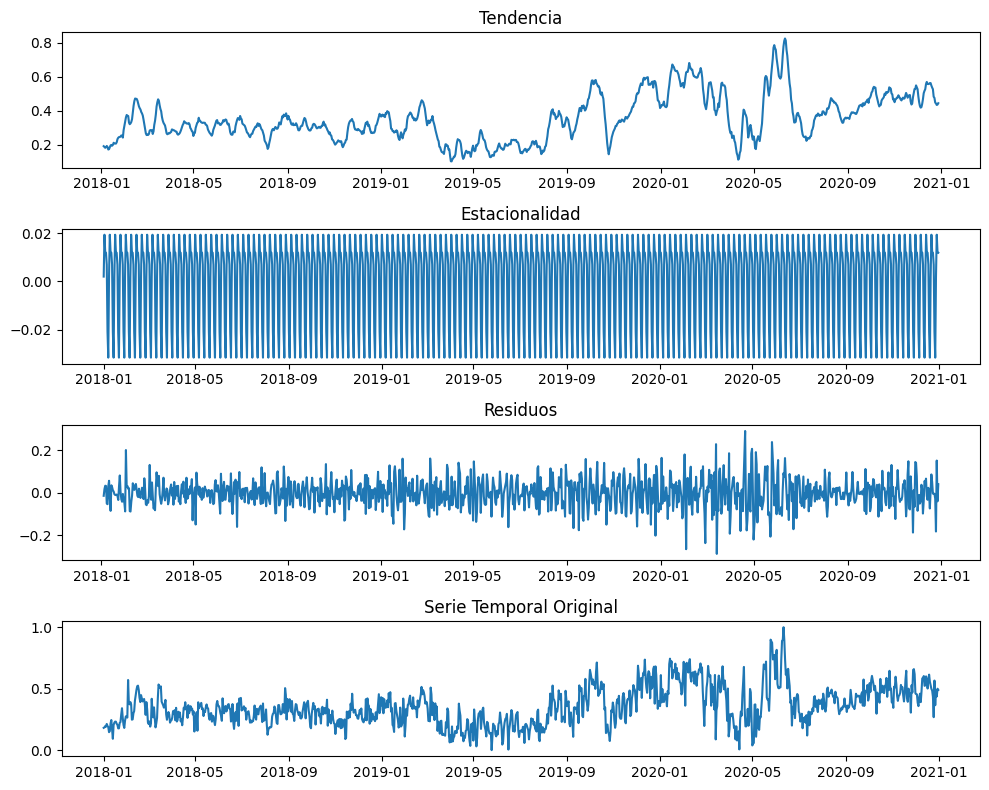

In [49]:
# Descomposición de series temporales
df_rango.set_index('Date', inplace=True)
decomposition = seasonal_decompose(df_rango['MBTU_daily'], model='additive')
# Visualización de la descomposición
plt.figure(figsize=(10, 8))

# Tendencia
plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Tendencia')

# Estacionalidad
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Estacionalidad')

# Residuos
plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residuos')

# Serie Temporal Original
plt.subplot(414)
plt.plot(df_rango['MBTU_daily'])
plt.title('Serie Temporal Original')

plt.tight_layout()
plt.show()

**Análisis resultados**
Se puede notar en la descomposición de la serie temporal se tiene una tendencia variante en el tiempo sin un patro muy claro. Una parte estacional que tiene concordancia con los datos pero de la mano con residuos de esta descomposición que tienen un comportamiento variable en los diferentes años.

In [50]:
# Test de Dicked Fuller
# Aplicar el test de Dickey-Fuller
result = sm.tsa.adfuller(df_rango['MBTU_daily'])

# Mostrar los resultados del test
print('Estadística ADF:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])

# Interpretación de los resultados
if result[1] <= 0.05:
    print("La serie temporal es estacionaria (rechazamos la hipótesis nula de la presencia de una raíz unitaria).")
else:
    print("La serie temporal no es estacionaria (no podemos rechazar la hipótesis nula de la presencia de una raíz unitaria).")

Estadística ADF: -4.595186010761769
Valor p: 0.00013183456334985879
Valores críticos: {'1%': -3.436369082756128, '5%': -2.8641976875421524, '10%': -2.5681850407995137}
La serie temporal es estacionaria (rechazamos la hipótesis nula de la presencia de una raíz unitaria).
